In [1]:
# -*- coding: utf-8 -*-
# based on https://danijar.com/variable-sequence-lengths-in-tensorflow/

import numpy as np
import random
import functools
import tensorflow as tf
import time
import re #regexp

from tensorflow.python.ops import rnn_cell, rnn
from sklearn.metrics import confusion_matrix #compute confusion_matrix
from matplotlib import pyplot as plt #display confusion_matrix

directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/'
directory_dataset = directory + 'data_nathan/'

file_training = "training.txt"
file_testing = "testing.txt"

saved_model = directory + "saved_sessions/all_actions_RNN.ckpt"

# Extract label names from text file
with open(directory + 'labels/name_of_labels_original.txt') as f:
    name_labels = [word for line in f for word in line.split()]
    #name_labels = np.asarray(name_labels) #list to array

feat_size = 63 #21 joints * 3 dimensions (xyz)
        
num_classes = 45
batch_size = 20
padding_size = 300

# Parameters
learning_rate = 0.003
n_epochs = 1 #100

# Network Parameters
seq_max_len = padding_size # Sequence max length
n_hidden = 100 # hidden layer num of features
n_classes = num_classes # linear sequence or not
max_seq_l = 120

p_dropout = 0.2 #1 #0.8



/home/nathan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data(filename):
    # Reads file containing features and returns features indexed by time
    x = []
    tmp_length = 0
    with open(filename) as f:
        for line in f:
            numbers_str = line.split()
            nums_float = [float(a) for a in numbers_str]
            x.append(nums_float)
            tmp_length =tmp_length+1
    f.close() #necessary ? supposed to be automatic
    tmp_val = np.min([tmp_length-1,max_seq_l])
    return x[1:]  # ignore the first line (num of frames)

def read_config(filename):
    # Reads config file and returns filenames and class label
    x = []
    with open(filename) as f:
        for line in f:
            line_split = line.split()
            x.append(line_split)
    f.close()
    return x

# one hot encoding
def num_to_idx(num):
    vec = np.zeros( shape=num_classes, dtype=np.float) #hardcode here
    vec[num] = 1
    return vec

def create_dataset(filename):
    # dataset is organized as NxLxD (N = num samples, L temporal length with padding, D feature dimension
    # labels is NxY where Y is one hot label vector

    dataset, labels, lengths = [], [], []
    files = read_config(filename)

    for i in files:
        
        tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
        tmp_labels = np.transpose(num_to_idx(int( i[1] ))) #i[1] = number between 1 and 45 (or as many classes there is)
        #tmp_labels = [0, 0, 1, 0, .. 0] = one-hot encoding of class value
        #tmp_data = list with variable len around 300 & each item in the list is a nested list of len 63 (=feat_size)

        if len(tmp_data)<300: #why 300, is that the longest sequence ? 300 = padding_size btw...
            
            #record tmp_data initial length before padding
            lengths.append(len(tmp_data))
            
             # Pads tmp_data with zeros until padding_size (300) so len(tmp_data) = 300 always with len 63 items
            tmp_data.extend([ [0.0] * feat_size ] * (padding_size - len(tmp_data)))  

            dataset.append(tmp_data)
            labels.append(tmp_labels) 

    return dataset, labels, lengths

#Not used in this notebook
def parameters_dataset(dataset):
    # this function extracts parameters for normalizing data... todo: reimplement because it sucks
    nsamples, _ , _ = dataset.shape

    valid_data = dataset[0,0,:]

    for i in range(nsamples):
        for j in range(padding_size):
            if np.sum(dataset[i,j,:]) != 0:

                valid_data = np.vstack((valid_data,dataset[i,j,:]))

            else:
                break

    mu = np.mean(valid_data,axis = 0)
    sigma = np.std(valid_data,axis = 0)
    max_val = np.max(valid_data,axis=0)
    min_val = np.min(valid_data,axis=0)

    return mu, sigma, min_val, max_val

#Not used in this notebook
def normalize_dataset(dataset, mu, sigma,max_val,min_val):
    nsamples, _ , _ = dataset.shape

    for i in range(nsamples):

        for j in range(padding_size):
            if np.sum(dataset[i,j,:]) != 0:

                # print(dataset[i, j, :])

                dataset[i,j,:] = -1+2*(dataset[i,j,:]-min_val)/(max_val-min_val+ np.finfo(np.float32).eps)

            else:
                break
    return dataset

#Called once when training RNN
def batch_generation(data,labels,lengths):

    nsamples,_,_ = data.shape

    indices = np.arange(nsamples)
    np.random.shuffle(indices)
    num_batches = int(np.floor(nsamples/batch_size))
    not_exact = 0

    if nsamples%batch_size != 0:
        not_exact = 1

    batches_data = np.empty(shape=[num_batches+not_exact,batch_size,padding_size,feat_size])
    batches_labels = np.empty(shape=[num_batches+not_exact,batch_size,num_classes]) #hardcode here with num_classes
    batches_lengths = np.empty(shape=[num_batches + not_exact, batch_size],dtype=np.int32)

    for x in range(num_batches):
        batches_data[x, :, :, :] = data[indices[batch_size*x:batch_size*(x+1)], :, :]
        batches_labels[x,:,:] = labels[indices[batch_size*x:batch_size*(x+1)], :]
        batches_lengths[x,:] = lengths[indices[batch_size*x:batch_size*(x+1)]]

    if not_exact > 0:
        to_complete = nsamples%batch_size
        tmp_data = data[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:,:]
        tmp_random = np.random.randint(0,nsamples-to_complete,batch_size-to_complete) # we complete last batch with random samples

        batches_data[num_batches]=np.concatenate((tmp_data,data[tmp_random,:,:]),axis=0)

        tmp_labels = labels[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:]
        batches_labels[num_batches] = np.concatenate((tmp_labels,labels[indices[tmp_random],:]))
        tmp_lengths = lengths[indices[batch_size*num_batches:batch_size*num_batches+to_complete]]
        batches_lengths[num_batches] = np.concatenate((tmp_lengths,lengths[indices[tmp_random]]))

    return batches_data, batches_labels, batches_lengths, num_batches+not_exact

In [3]:
# ==========
#   MODEL
# ==========

tf.reset_default_graph() #Clear computational graph to prevent error

# Load training and testing data
train_data, train_labels, train_lengths = create_dataset(file_training)
test_data, test_labels, test_lengths = create_dataset(file_testing)

#cast to numpy array
train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
train_lengths = np.asarray(train_lengths,dtype=np.int32)
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)
test_lengths = np.asarray(test_lengths)

#print("Normalizing data")
# mu_train, sigma_train, min_val, max_val = parameters_dataset(train_data)
#print("Mean and Std estimated")
# train_data = normalize_dataset(train_data, mu_train, sigma_train, min_val, max_val)
#print("Training normalized")
# test_data = normalize_dataset(test_data, mu_train, sigma_train, min_val, max_val)
#print("Testing normalized")

(samples, rows, row_size) = train_data.shape

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, feat_size])
y = tf.placeholder("float", [None, n_classes])

# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}
keep_prob = tf.placeholder(tf.float32)

In [4]:
def dynamicRNN(x, seqlen, weights, biases, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, feat_size])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, seq_max_len, 0) # tf.split(value, num_or_size_splits, axis)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    
    #Operator adding dropout to inputs and outputs of the given cell.
    lstm = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob) 
    
    #Added to have 2 layers LSTM, not used here.
    layers = 1
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * layers)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)
    
    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

pred = dynamicRNN(x, seqlen, weights, biases, keep_prob)

# Evaluate model 
prediction = tf.argmax(pred,1) # for each prediction, keep class with highest level of confidence (tests X classes)
correct_pred = tf.equal(prediction, tf.argmax(y,1)) #output 0 & 1 vector, y is supposed to have true labels
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) #mean of above

#Create a saver object which will save all the variables
saver = tf.train.Saver()

In [5]:
#SELF-CONTAINED

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()
    
# Launch the graph
with tf.Session() as sess:
    
    sess.run(init)
    
    max_acc = 0.0;
    max_epoch = 0;
    best_labels = []
    
    # Keep training until reach max iterations
    for epoch in range(n_epochs):

        (batch_x, batch_y, batch_seqlen, n_batches) = batch_generation(train_data, train_labels, train_lengths)
        
        start = time.time()

        for i in range(n_batches):


            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
                                                    seqlen: batch_seqlen[i,:], keep_prob: p_dropout})
            # Calculate batch accuracy
            # acc = sess.run(accuracy, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
            #                                     seqlen: batch_seqlen[i]})
            # # Calculate batch loss
            # loss = sess.run(cost, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
            #                                     seqlen: batch_seqlen[i]})
        
        # Test accuracy on this epoch    
        test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
        
        #Save best testing results
        if test_acc > max_acc: 
            
            #Save the best accuracy and predictions
            max_acc = test_acc; max_epoch = epoch
            #gives the confidence score of every class at output along columns (dim 1)
            labels = pred.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
            # pred_labels = tf.argmax(labels, 1) OR
            pred_labels = prediction.eval(feed_dict={x: test_data, y: test_labels, seqlen: test_lengths, keep_prob: 1.0})
            #test_labels is one_hot. Want 1-D like best_labels
            true_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64)
            
            #Save the graph (the best model)
            saver_path = saver.save(sess, saved_model) 
            print("Saving model at epoch %i and path %s" % (epoch, saver_path))
                
        print('Epoch {:2d} accuracy {:3.1f}% in {:3.1f} seconds'.format(epoch, 100 * test_acc, time.time() - start))
        print('max_acc {:3.1f}% at epoch {:2d} \n'.format(max_acc*100, max_epoch))

    print ("Optimization Finished!")

    # ToDo
    # Get training accuracy and plot it along test accuracy 
    # Add a validation set accuracy to train without overfitting
    

/home/nathan/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Saving model at epoch 0 and path /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/all_actions_RNN.ckpt
Epoch  0 accuracy 16.0% in 100.1 seconds
max_acc 16.0% at epoch  0 

Optimization Finished!


In [6]:
#Display confusion matrix
def confusion_mtx(true, pred, name_labels, num_classes):
    
    cm = confusion_matrix(true, pred)

    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(num_classes), name_labels, rotation=90)
    plt.yticks(range(num_classes), name_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    #TODO
    #Have a checkerboard figure to track classes easily
    #Have white background for better error reading for colorbar
    #Rotate 45 the vertical axis

#Display confidence level bar histogram 
def confidence_probability (scores, pred_class, true_class, name_labels, atog):
    
    pred_class = atog[pred_class] #if no grouping, atog[x]=x, so no change happens
    true_class = atog[true_class]
    
    format_scores = scores - np.amin(scores)
    format_scores = format_scores / np.amax(format_scores)
    
    #y = scores
    y = format_scores #probabilities made from normalising on this 1 score (not on the 569 scores)
    x = range(len(scores)) #as much scores as there is in y (45)
    
    plt.figure(figsize=(20,4))
    
    barlist = plt.bar(x,y, width=0.7)

    import randomcolor
    colors = randomcolor.RandomColor().generate(count=len(name_labels)) #as many group or actions    
    for i in range(len(barlist)): barlist[i].set_color(colors[atog[i]])
    
    plt.title('Predicted class ' + str(pred_class) + ' ' + name_labels[pred_class] 
                 + ' for class ' + str(true_class) + ' ' + name_labels[true_class],
                 fontsize=18)
    
    name_labels_extended = [name_labels[atog[i]] for i in range(len(scores))] 
    
    plt.xticks(x, name_labels_extended, rotation=90, fontsize=18)
    
    plt.show()
    
    #ToDo
    # Be able to know the name of sample seq that fails 

In [7]:
#Extract action-to-group dictionary & group labels

#og = object group mg=motion group
#object & motion group recognised with 'motion_object' in label text file

def action_to_group (location, family):

    with open(location, 'r') as f:
        pattern = '_(\w+)' #for Object by default
        if family == 'Motion': pattern = '(\w+)_' #add patterns like this as a list
        regexp = re.compile(pattern)
        get = re.findall( regexp, f.read() )

    atog = list() #action to group dictionary 
    g_labels = list() 
    for i in get:
        #check if group already exists
        if i not in g_labels: #extract group number as index of word in submitted & add it to action group dictionary
            g_labels.append(i)
        atog.append( g_labels.index(i) ) 

    #num_g = len(g_labels) FYI
    
    return (atog, g_labels) 

#ToDo
# With a python dictionary and line.split()

#Evaluate accuracy & conf_mtx on the group
def evaluate_grouping (atog, g_labels, family):
    
    num_g = len(g_labels)
    
    #Convert labels from action to group
    true_g_labels = np.asarray([atog[i] for i in true_labels])
    pred_g_labels = np.asarray([atog[i] for i in pred_labels])
    
    correct_pred = np.equal(true_g_labels, pred_g_labels) #output 0 & 1 vector
    accuracy_g = np.mean(correct_pred) #mean of above
    print('Individual Accuracy %.2f %%' % float(100*max_acc))
    print('Group %s Accuracy %.2f %% with %i groups' % (family, float(100*accuracy_g), num_g))
    
    confusion_mtx(true_g_labels, pred_g_labels, g_labels, num_g)   

#ToDo
# Colored bar plot by group to see if diff groups or actions inside same group always steal the show 

In [8]:
#Save results of normal RNN

with tf.Session() as sess:
    
    # Restore variables from disk.
    saver.restore(sess, saved_model)
    print("Model restored.")
    
    #Save on disk to not have to retrain to get results
    location = directory + 'results/original_RNN/all/' 
    np.save(location + 'labels.npy', labels)    # .npy extension is added if not given
    np.save(location + 'pred_labels.npy', pred_labels) 
    np.save(location + 'true_labels.npy', true_labels) 
    

INFO:tensorflow:Restoring parameters from /home/nathan/Documents/FYP_code/LSTM1_guillermo/saved_sessions/all_actions_RNN.ckpt
Model restored.


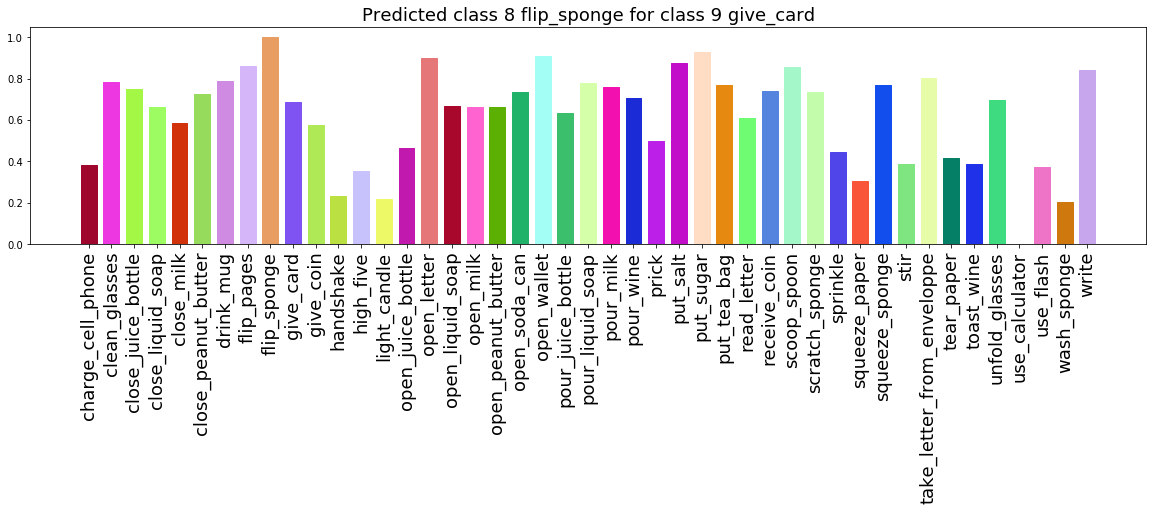

Accuracy 15.99 %


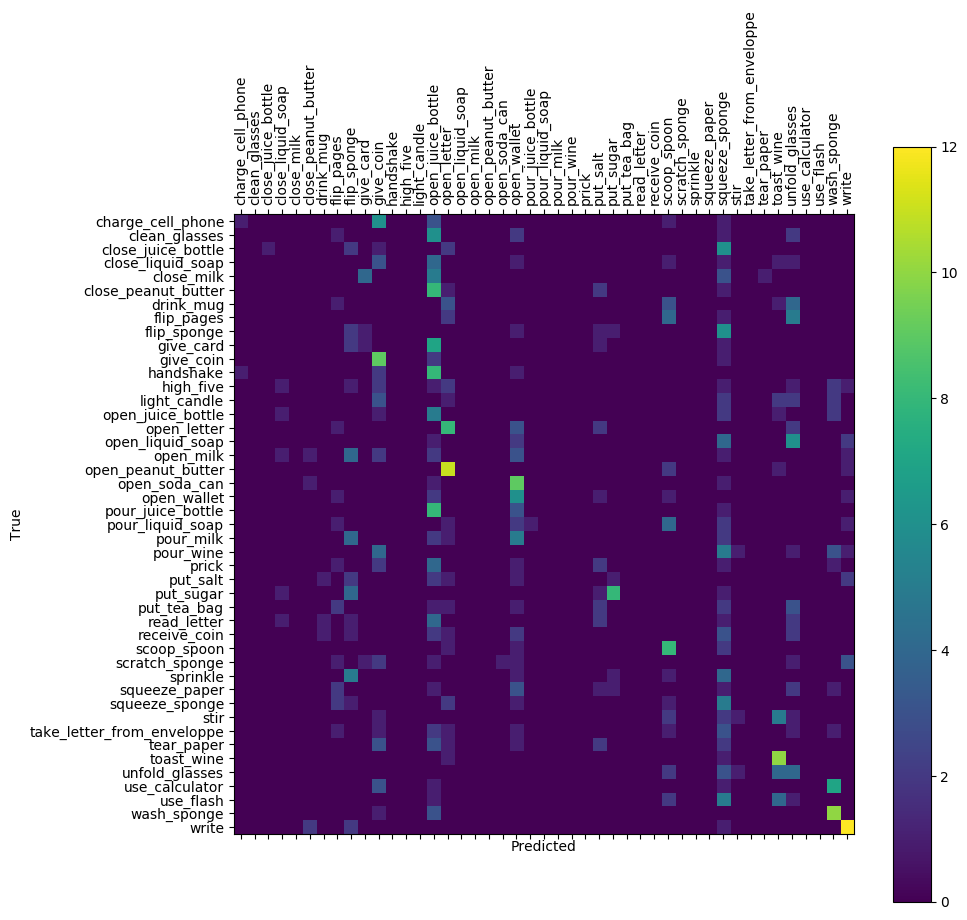

In [9]:
#All actions - no grouping

location = directory + 'results/original_RNN/all/' 
(labels, pred_labels, true_labels) = ( np.load(location + 'labels.npy'), 
                                       np.load(location + 'pred_labels.npy'),
                                       np.load(location + 'true_labels.npy') )

ite = 18
confidence_probability (labels[ite,:], pred_labels[ite], true_labels[ite], name_labels, range(len(name_labels)))

print('Accuracy %.2f %%' % float(100*max_acc))  
confusion_mtx(true_labels, pred_labels, name_labels, num_classes)

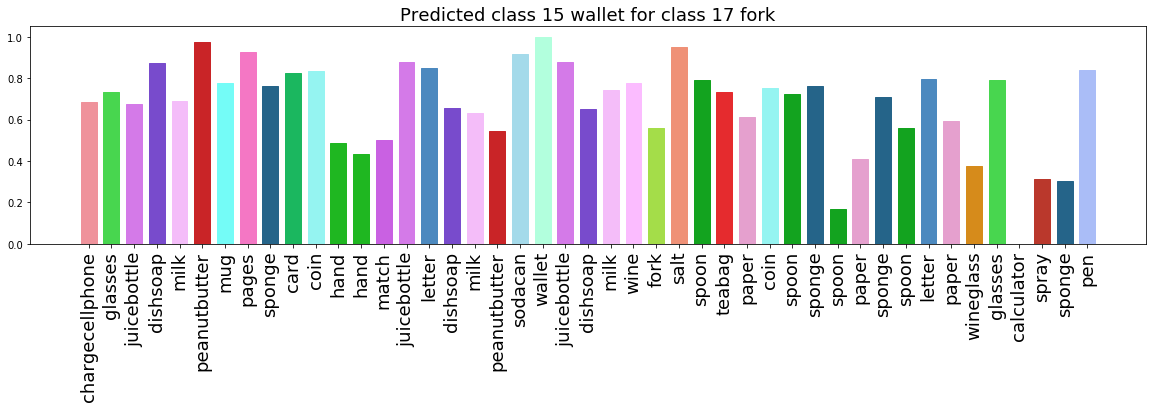

Individual Accuracy 15.99 %
Group Object Accuracy 19.86 % with 26 groups


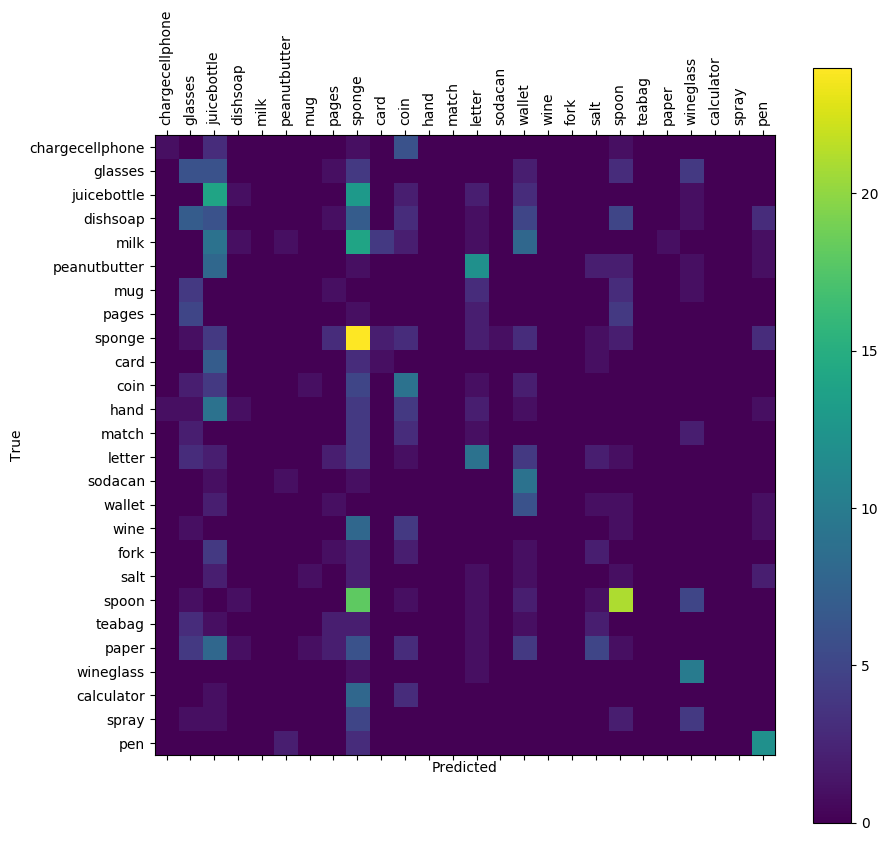

In [10]:
#Object grouping

family = 'Object'

location = directory + 'results/original_RNN/all/' 
(labels, pred_labels, true_labels) = ( np.load(location + 'labels.npy'), 
                                       np.load(location + 'pred_labels.npy'),
                                       np.load(location + 'true_labels.npy') )

(atog, g_labels) = action_to_group(directory + 'labels/grouping_1/object_group_labels.txt', family)

ite = 51
confidence_probability (labels[ite,:], pred_labels[ite], true_labels[ite], g_labels, atog)

evaluate_grouping (atog, g_labels, family)

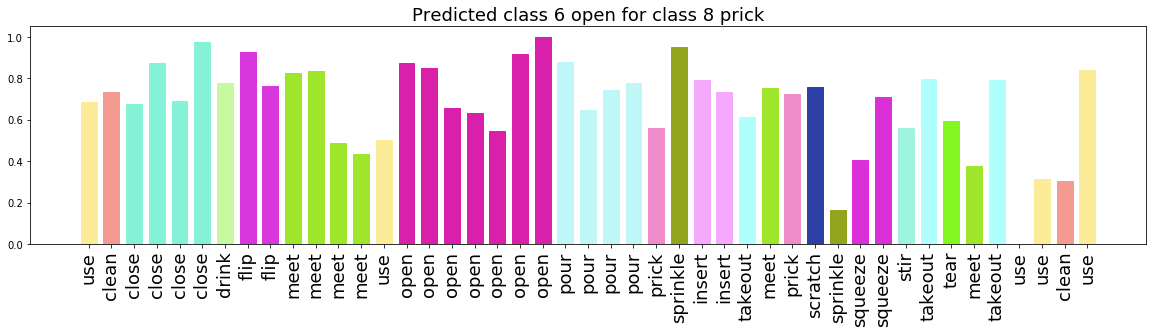

Individual Accuracy 15.99 %
Group Motion Accuracy 23.55 % with 16 groups


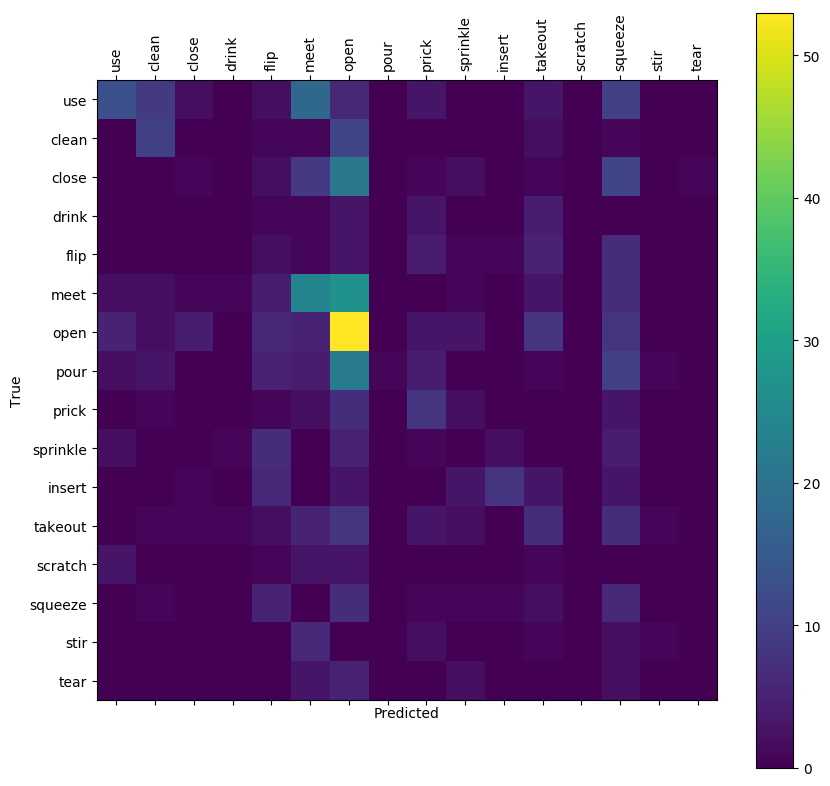

In [13]:
#Motion grouping

family = 'Motion'

location = directory + 'results/original_RNN/all/' 
(labels, pred_labels, true_labels) = ( np.load(location + 'labels.npy'), 
                                       np.load(location + 'pred_labels.npy'),
                                       np.load(location + 'true_labels.npy') )

(atog, g_labels) = action_to_group(directory + 'labels/grouping_1/motion_group_labels.txt', family)

ite = 51
confidence_probability (labels[ite,:], pred_labels[ite], true_labels[ite], g_labels, atog)

evaluate_grouping (atog, g_labels, family)    